In [1]:
import os
import json
from datetime import datetime
import pandas as pd
from collections import Counter
import spacy
from spacy.matcher import Matcher
from spacy.language import Language
from sentence_transformers import SentenceTransformer
import numpy as np 
import seaborn as sns
import scipy
from tqdm import tqdm
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [2]:
jd_dir = "Data/job-description/"
resume_dir = "Data/resume/"
path_degrees = 'Data/degrees.jsonl'
path_data = 'Data/data.csv'

# Dataset

## Chuyển đổi data Json sang DataFrame

In [3]:
def read_json_files_to_dataframe(folder_path, type_file):
    dfs = []

    for filename in os.listdir(folder_path):
        if filename.endswith('.json'):
            file_path = os.path.join(folder_path, filename)
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                    
                    if type_file == 1:
                        dict_data = {
                            "id": filename.replace(".json", ""),
                            "title": [data.get('title', [])],
                            "description": [data.get('description', [])],
                            "requirements": [data.get('requirements', [])],
                            "required_skills": [data.get('required_skills', [])]
                        }
                        dfs.append(pd.DataFrame(dict_data))
                    else:
                        gpas = [data["educations"][id]["gpa"] for id in range(len(data.get("educations", [])))]
                        majors = [data["educations"][id]["major"] for id in range(len(data.get("educations", [])))]
                        diplomas = [data["educations"][id]["diploma"] for id in range(len(data.get("educations", [])))]
                       
                        positions = [data["experiences"][id]["position"] for id in range(len(data.get("experiences", [])))]
                        
                        end_time = [datetime.fromisoformat(data["experiences"][id]["end_time"][:-1]) for id in range(len(data.get("experiences", [])))]  # Loại bỏ "Z" ở cuối chuỗi
                        start_time = [datetime.fromisoformat(data["experiences"][id]["start_time"][:-1]) for id in range(len(data.get("experiences", [])))]
                        
                        years = []
                        for i in range(len(end_time)):
                            years.append(str(round((end_time[i] - start_time[i]).days / 365, 1)))
                            
                        dict_data = {
                            "id": filename.replace(".json", ""),
                            "skills": [data.get('skills', [])],
                            "fulltext": [data.get('fulltext', [])],
                            "degree": [diplomas],
                            "educations_gpa": [gpas],
                            "educations_major": [majors],
                            "positions": [positions],
                            "years_positions":[years]
                        }
                        dfs.append(pd.DataFrame(dict_data))
            except Exception as e:
                print(f"Error file {file_path}: {str(e)}")

    if len(dfs) > 0:
        final_df = pd.concat(dfs, ignore_index=True)
        return final_df
    else:
        print("No JSON file is found in the folder.")
        return None

In [4]:
jd_df = read_json_files_to_dataframe(jd_dir, 1)
resume_df = read_json_files_to_dataframe(resume_dir, 2)

## Data csv

In [5]:
data_csv = pd.read_csv(path_data)

In [6]:
data_csv = data_csv.drop(columns = 'Unnamed: 0')
data_csv.drop(0,  axis = 'rows', inplace = True)
data_csv = data_csv.reset_index(drop=True)

In [7]:
data_csv

,job_description_id,resume_id,experience,education,language,title_score,description_score,yoe_score,overall_score,cosine_score_matching_skill,label
0,4385,4385,0.905469,0,1.0,1.000000,0.810938,NaN,0.898703,0.452085,1
1,4515,4515,0.808731,0,0.0,0.696288,0.921175,NaN,0.692099,0.292798,1
2,5184,5184,0.209289,0,0.0,0.209289,NaN,NaN,0.355047,0.523493,1
3,4334,4334,0.669163,0,0.0,0.669163,NaN,NaN,0.740888,0.677293,1
4,4993,4993,0.741059,0,0.0,0.741059,NaN,NaN,0.874653,0.836064,1
...,...,...,...,...,...,...,...,...,...,...,...
9722,4982,4287,0.538705,0,0.0,0.374487,0.702924,NaN,0.538705,0.218218,0
9723,4982,4448,0.557140,0,0.0,0.390805,0.723474,NaN,0.557140,0.113961,0
9724,4982,4329,0.543104,0,0.0,0.377300,0.708909,NaN,0.543104,0.150188,0
9725,4982,4289,0.521524,0,0.0,0.327424,0.715624,NaN,0.521524,0.218218,0


In [8]:
data_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9727 entries, 0 to 9726
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   job_description_id           9727 non-null   int64  
 1   resume_id                    9727 non-null   int64  
 2   experience                   9727 non-null   float64
 3   education                    9727 non-null   int64  
 4   language                     9727 non-null   float64
 5   title_score                  9721 non-null   float64
 6   description_score            3848 non-null   float64
 7   yoe_score                    0 non-null      float64
 8   overall_score                9727 non-null   float64
 9   cosine_score_matching_skill  9573 non-null   float64
 10  label                        9727 non-null   int64  
dtypes: float64(7), int64(4)
memory usage: 836.0 KB


In [9]:
data_csv.describe()

,job_description_id,resume_id,experience,education,language,title_score,description_score,yoe_score,overall_score,cosine_score_matching_skill,label
count,9727.000000,9727.000000,9727.000000,9727.0,9727.000000,9721.000000,3848.000000,0.0,9727.000000,9573.000000,9727.000000
mean,4881.466536,4524.032487,0.486096,0.0,0.007094,0.432949,0.699072,NaN,0.487609,0.262319,0.090161
std,283.217560,299.550006,0.151952,0.0,0.083929,0.151902,0.141374,NaN,0.157049,0.195192,0.286428
min,4287.000000,4287.000000,0.000000,0.0,0.000000,0.057000,0.000000,NaN,0.000000,0.000000,0.000000
25%,4648.000000,4312.500000,0.372895,0.0,0.000000,0.319333,0.654406,NaN,0.375911,0.096693,0.000000
50%,4934.000000,4385.000000,0.505141,0.0,0.000000,0.417615,0.710449,NaN,0.503303,0.236443,0.000000
75%,5132.000000,4595.000000,0.585823,0.0,0.000000,0.540059,0.776796,NaN,0.584627,0.390704,0.000000
max,5322.000000,5322.000000,1.000000,0.0,1.000000,1.000000,0.936667,NaN,1.000000,1.000000,1.000000


In [10]:
data_csv = data_csv.drop(columns = 'education')
data_csv = data_csv.drop(columns = 'yoe_score')

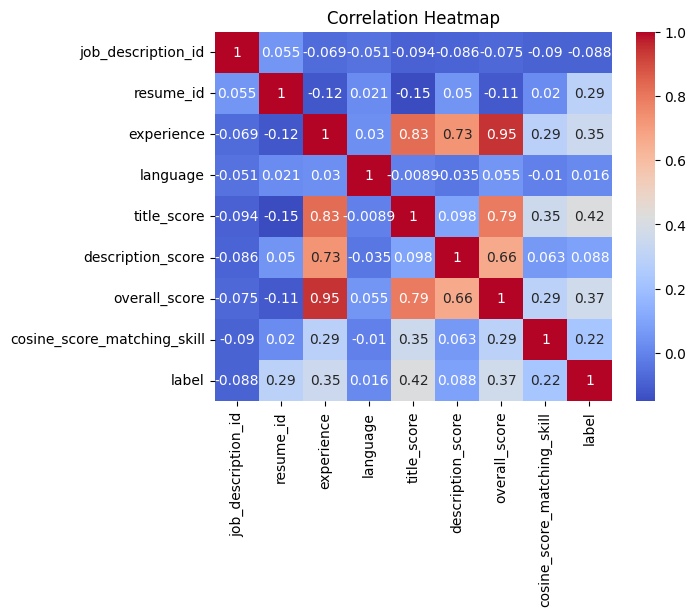

In [11]:
correlation_matrix = data_csv.corr(numeric_only=False)

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.savefig('Correlation.png')
plt.show()


## Thống kê data

### JD

In [12]:
jd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 897 entries, 0 to 896
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               897 non-null    object
 1   title            897 non-null    object
 2   description      885 non-null    object
 3   requirements     897 non-null    object
 4   required_skills  897 non-null    object
dtypes: object(5)
memory usage: 35.2+ KB


In [13]:
jd_df.head()

,id,title,description,requirements,required_skills
0,4287,React Native Team leader,You will be joining our Tech team to build app...,- 1+ years experience working with ReactJS/Rea...,"[reactjs, git, javascript, jira, unit test, re..."
1,4288,[Test] Ruby Developer,Analyse system requirement and review specific...,At least 1-year experience working with web-ba...,"[github, bitbucket, gitlab, mvc, oop, css, tes..."
2,4289,Front End Reactive (Reactjs / Angularjs / Vuejs),"- Kết hợp với Backend Developer, Product Manag...",- Có trên 1 năm kinh nghiệm làm việc với React...,"[typescript, reactjs, javascript, networking, ..."
3,4290,"Java Backend Developer (Multi-Thread, High Per...",•\tDeveloping the backend system for the Distr...,"•\tHave experience with Java Core, especially ...","[structure, algorithm, data structure, design ..."
4,4291,Executive Assistant To The CEO,- Assist the CEO to make decisions for operati...,- You have to know more about operations than ...,"[team management, management, analysis, proble..."


In [14]:
# Thống kê và đếm tất cả các title
title_counts = jd_df['title'].value_counts()
print(title_counts)

title
Senior IOS developer                               17
Senior .NET .Netcore developer                     16
Senior Front End Developer (ReactJs or VueJS …)    16
Senior Magento/Shopify developer (Remote)          15
Senior Front-end                                   14
                                                   ..
Front-end Developer (Middle Level - Senior )        1
PRODUCT MANAGER, FIN-TECH (ZALOPAY E-WALLET)        1
Trưởng Phòng Nhân Sự                                1
REACT NATIVE FRONT END DEV                          1
Mobile Developer (Android/IOS)                      1
Name: count, Length: 261, dtype: int64


In [15]:
# Thống kê tất cả các skill của jd
all_skills = []
for skills in jd_df['required_skills']:
    for skill in skills:
        all_skills.append(skill)
print(all_skills)

['reactjs', 'git', 'javascript', 'jira', 'unit test', 'react native', 'github', 'bitbucket', 'gitlab', 'mvc', 'oop', 'css', 'testing', 'linux', 'sql', 'javascript', 'rail', 'git', 'unit testing', 'html', 'ruby', 'typescript', 'reactjs', 'javascript', 'networking', 'angular', 'html5', 'structure', 'algorithm', 'data structure', 'design pattern', 'management', 'java core', 'software development', 'problem solving', 'software design pattern', 'java', 'team management', 'management', 'analysis', 'problem solving', 'data analysis', 'finance', 'making decision', 'problem solving skill', 'python', 'project estimation', 'agile', 'process development', 'stack', 'software development', 'rail', 'communication skill', 'ruby', 'le', 'javascript framework', 'package manager', 'npm', 'vuejs', 'javascript', 'bootstrap', 'yarn', 'restful', 'git', 'problem solving', 'unit test', 'html', 'es6', 'css framework', 'css', 'problem solving skill', 'software development', 'agile', 'golang', 'management', 'rest

In [16]:
# Thống kê các skill của jd
skill_counts = Counter(all_skills)
sorted_skills = sorted(skill_counts.items(), key=lambda x: x[1], reverse=True)

print("number skill =", len(sorted_skills))
for skill, count in sorted_skills:
    print(f"{skill}: {count}")


number skill = 487
javascript: 213
communication skill: 189
management: 183
git: 182
css: 167
problem solving: 149
html: 148
java: 142
restful: 125
database: 121
software development: 117
reactjs: 113
agile: 96
testing: 87
mysql: 85
structure: 82
php: 82
html5: 81
design pattern: 81
le: 81
mvc: 75
algorithm: 75
bootstrap: 75
react native: 74
sql: 73
analysis: 73
mongodb: 73
io: 71
css3: 71
oop: 69
data structure: 69
teamwork: 67
python: 66
rest: 66
redux: 66
c#: 64
stack: 63
es6: 61
object oriented: 59
svn: 57
vuejs: 55
linux: 54
jquery: 54
aws: 53
cloud: 51
angular: 50
critical thinking: 50
android: 49
marketing: 49
javascript framework: 48
spring: 48
json: 47
azure: 47
css framework: 46
excel: 46
ruby: 45
microsoft: 45
postgresql: 44
website development: 44
swift: 43
unit test: 41
protocol: 40
microservices: 39
rail: 36
written communication: 35
sales: 35
redis: 33
typescript: 31
problem solving skill: 30
process development: 30
can: 29
laravel: 29
continuous integration: 29
memory m

In [17]:
# Hiển thị các hàng có giá trị null
rows_with_null = jd_df[jd_df.isnull().any(axis=1)]
print(len(rows_with_null))
rows_with_null

12


,id,title,description,requirements,required_skills
8,4295,QA Tester,None,- Có ít nhất 2 năm kinh nghiệm QA/Tester.\n- C...,"[rest, analysis, can, tester]"
10,4297,QA Tester,None,- Có ít nhất 2 năm kinh nghiệm QA/Tester.\n- C...,"[rest, analysis, can, tester]"
13,4300,QA Tester,None,- Có ít nhất 2 năm kinh nghiệm QA/Tester.\n- C...,"[rest, analysis, can, tester]"
29,4316,QA Tester,None,- Có ít nhất 2 năm kinh nghiệm QA/Tester.\n- C...,"[rest, analysis, can, tester]"
46,4337,QA Tester,None,- Có ít nhất 2 năm kinh nghiệm QA/Tester.\n- C...,"[rest, analysis, can, tester]"
49,4341,Blockchain Developer (In Japan),None,- Với các vị trí này thì phải có bằng tốt nghi...,[]
148,4452,QA Tester,None,- Có ít nhất 2 năm kinh nghiệm QA/Tester.\n- C...,"[rest, analysis, can, tester]"
156,4460,QA Tester,None,- Có ít nhất 2 năm kinh nghiệm QA/Tester.\n- C...,"[rest, analysis, can, tester]"
200,4511,AI Developer (In Japan),None,- Với các vị trí này thì phải có bằng tốt nghi...,[]
201,4512,QA Tester,None,- Có ít nhất 2 năm kinh nghiệm QA/Tester.\n- C...,"[rest, analysis, can, tester]"


### Resume

In [18]:
resume_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 897 entries, 0 to 896
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                897 non-null    object
 1   skills            897 non-null    object
 2   fulltext          897 non-null    object
 3   degree            897 non-null    object
 4   educations_gpa    897 non-null    object
 5   educations_major  897 non-null    object
 6   positions         897 non-null    object
 7   years_positions   897 non-null    object
dtypes: object(8)
memory usage: 56.2+ KB


In [19]:
resume_df.head()

,id,skills,fulltext,degree,educations_gpa,educations_major,positions,years_positions
0,4287,"[docker, cryptocurrency, javascript, ams, mana...","Nguyen Duy Khanh\nHanoi, Vietnam\n (+84)36364...","[Bachelors, Bachelors]","[None, None]","[Business English, Khoa học máy tính]","[React - native developer, React - native deve...","[0.2, 0.6, 1.6]"
1,4288,"[git, css, agile, reactjs, html, linux, full s...",Hoang Minh Dung\nE-mail: itmanvn07@gmail.com §...,[Bachelors],[None],[Kỹ thuật phần mềm],"[Senior Full Stack Developer, PHP Team Leader,...","[6.3, 2.1, 2.1]"
2,4289,"[angular, java, mssql, management, studio, exc...",Nguyen Nhut Thanh\nAngular Developer\nDate of...,[Bachelors],[7.46],[Công nghệ thông tin],"[Angular developer, Developer, Developer]","[5.2, 1.2, 0.8]"
3,4290,"[studio, machine to machine, user interface, j...",CURRICULUM VITAE \nPERSONAL DETAILS \n• Name...,"[Other, Other, Bachelors, Other]","[None, None, 2.84, None]","[None, None, Mechatronics, None]","[None, Java web developer, Customer relationsh...","[5.2, 1.9, 2.2, 0.3, 0.2, 1.1, 0.5, 4.8]"
4,4291,"[community development, testing, analysis, pro...",Résumé \nPERSONAL PROFILE \nFull name: Phan T...,[Bachelors],[None],[Kinh tế quốc tế],"[Associate/ Senior Project Manager, Project Ma...","[0.6, 1.7, 1.1]"


In [20]:
# Thống kê tất cả các kỹ năng từ resume
all_skills = resume_df['skills'].explode()

skills_counts = all_skills.value_counts()

# In ra 10 kỹ năng phổ biến nhất
print(skills_counts.head(10))


skills
management    604
javascript    424
database      413
html          377
css           368
mysql         357
git           352
sql           348
java          335
analysis      295
Name: count, dtype: int64


In [21]:
# Hiển thị các hàng có giá trị null
rows_with_null = resume_df[resume_df.isnull().any(axis=1)]
print(len(rows_with_null))
rows_with_null

0


,id,skills,fulltext,degree,educations_gpa,educations_major,positions,years_positions


# Trích xuất thông tin

## Tạo các parttern để trích xuất thông tin

In [22]:
# Tải model English của Spacy
nlp = spacy.load("en_core_web_sm")
Matcher_NER = Matcher(nlp.vocab)

In [23]:
def load_patterns_from_jsonl(file_path):
    patterns = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            pattern = json.loads(line)
            patterns.append(pattern)
    return patterns

In [24]:
# Load pattern cho trích xuất thông tin degree
patterns_degrees = load_patterns_from_jsonl(path_degrees)
[Matcher_NER.add(pattern['label'], [pattern['pattern']]) for pattern in patterns_degrees]

[None, None, None, None, None, None, None, None, None, None, None, None, None]

In [25]:
# Tạo nhãn tùy chỉnh "NUM" để gán cho các số

@Language.component("NUM")
def set_custom_tag(doc):
    for token in doc:
        if token.text.isdigit():
            token.tag_ = "NUM"
    return doc

# Thêm component tùy chỉnh vào pipeline của SpaCy
nlp.add_pipe("NUM", last=True)

<function __main__.set_custom_tag(doc)>

In [26]:
#Thêm pattern để nhận diện số năm kinh nghiệm yêu cầu
pattern_year_experience = [{"POS": "NUM"},{"IS_PUNCT": True, "OP": "?"}, {"TEXT":{"REGEX": "^year.?.?$"}}]
Matcher_NER.add("Year of exp", [pattern_year_experience])

In [27]:
#Thêm pattern nhận diện lĩnh vực kinh nghiệm
pattern_major_exp = pattern_year_experience + [{"OP": "*"},{"TEXT": {"REGEX":".?\n$"}}]
Matcher_NER.add("Major of exp", [pattern_major_exp])

## NER

### Trích xuất Degree yêu cầu của JD

In [28]:
def match_degree_jd(folder_path, matcher, nlp):
    dfs = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.json'):
            file_path = os.path.join(folder_path, filename)
            try:        
                with open(file_path, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                    requirement = str(data.get("requirements")).replace("\n", " ")
                    text = nlp(requirement)
                    matches = matcher(text)
                    req_deg = None
                    for match_id, start, end in matches:
                        envs = nlp.vocab.strings[match_id]
                        labels_parts = envs.split('|')
                        if labels_parts[0] == 'DEGREE':
                            req_deg = labels_parts[1]
                    dict_data = {
                        "id": filename.replace(".json", ""),
                        "requirements_degree": [req_deg],
                    }
                    dfs.append(pd.DataFrame(dict_data))
            except Exception as e:
                print(f"Error file {file_path}: {str(e)}")
    if len(dfs) > 0:
        final_df = pd.concat(dfs, ignore_index=True)
        return final_df
    else:
        print("No JSON file is found in the folder.")
        return None


In [29]:
jd_degree_df = match_degree_jd(jd_dir, Matcher_NER, nlp)

In [30]:
jd_degree_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 897 entries, 0 to 896
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   897 non-null    object
 1   requirements_degree  119 non-null    object
dtypes: object(2)
memory usage: 14.1+ KB


In [31]:
print(jd_degree_df['requirements_degree'].value_counts())

requirements_degree
Bachelors    94
PhD          15
Masters      10
Name: count, dtype: int64


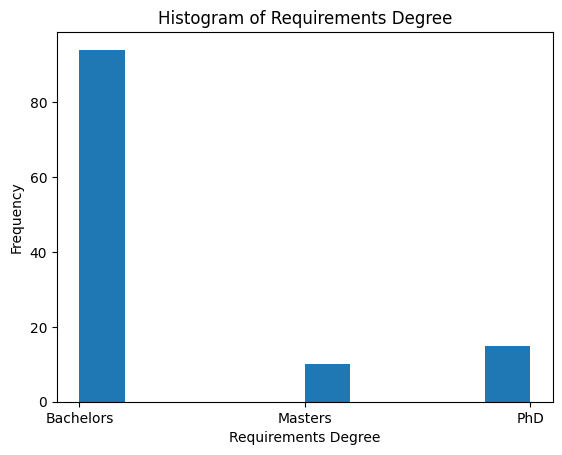

In [32]:
# Vẽ histogram cho cột 'requirements_degree'
filtered_df = jd_degree_df.dropna(subset=['requirements_degree'])
plt.hist(filtered_df.loc[:, 'requirements_degree'])
plt.xlabel('Requirements Degree')
plt.ylabel('Frequency')
plt.title('Histogram of Requirements Degree')
plt.savefig('hist_degree.png')
plt.show()

In [33]:
jd_degree_df.head(10)

,id,requirements_degree
0,4287,None
1,4288,None
2,4289,None
3,4290,None
4,4291,Bachelors
5,4292,None
6,4293,None
7,4294,None
8,4295,None
9,4296,None


### Trích xuất experience

In [34]:
def extract_infor_year_major(text, matcher, nlp):
    year = []
    major1 = []
    major = []
    text_doc = nlp(text)
    matches = matcher(text_doc)
    for match_id, start, end in matches:
        if nlp.vocab.strings[match_id] == "Year of exp":
            year.append(text_doc[start : end])
        if nlp.vocab.strings[match_id] == "Major of exp":
            major1.append(text_doc[start : end])
    if len(year) == 0:
        return year, major
    for index in range(len(year)):
        if index + 1 > len(major1):
            major.append(nlp("NULL"))
        else:
            major_words = [token.text for token in year[index]]
            major.append(nlp(" ".join([token.text for token in major1[index] if token.text not in major_words])))
    return year, major

In [35]:
def extract_major_and_exp(folder_path, matcher, nlp):
    dfs = []
    # Lặp qua tất cả các tệp trong thư mục
    for filename in os.listdir(folder_path):
        if filename.endswith('.json'):
            file_path = os.path.join(folder_path, filename)
            try:        
                with open(file_path, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                    requirements = data['requirements'].replace("+","-")
                    [year, major] = extract_infor_year_major(requirements, matcher, nlp)
                
                    requirements_years = [year[index].text.replace("\n", "") for index in range(len(year))]
                    requirements_major = [major[index].text.replace("\n", "") for index in range(len(year))]
                    
                    if len(requirements_years) == 0:
                        requirements_years = None
                    if len(requirements_major) == 0:
                        requirements_major = None
                    dict_data = {
                        "id": filename.replace(".json", ""),
                        "requirements_year": [requirements_years],
                        "requirements_major":[requirements_major]
                    }
                    dfs.append(pd.DataFrame(dict_data))
                
            except Exception as e:
                print(f"Error file {file_path}: {str(e)}")
    # Hợp nhất tất cả các DataFrame tạm thời thành một DataFrame chung
    if len(dfs) > 0:
        final_df = pd.concat(dfs, ignore_index=True)
        return final_df
    else:
        print("No JSON file is found in the folder.")
        return None

In [36]:
major_and_exp_jd_df = extract_major_and_exp(jd_dir, Matcher_NER, nlp)


In [37]:
major_and_exp_jd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 897 entries, 0 to 896
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  897 non-null    object
 1   requirements_year   555 non-null    object
 2   requirements_major  555 non-null    object
dtypes: object(3)
memory usage: 21.1+ KB


In [38]:
pd.set_option('display.max_colwidth', 5000)
major_and_exp_jd_df[2:8]

,id,requirements_year,requirements_major
2,4289,None,None
3,4290,[2 years-],[) ]
4,4291,"[5-year, 1 year]","[working experience and 1 -2 experience in team management , experience in E - commerce or Tech startup ]"
5,4292,None,None
6,4293,"[1,5 years]",[’ experience at web applications ]
7,4294,[3- years],[’ experience as a Software Developer ]


In [39]:
jd_df = jd_df.drop(columns = ['description'])
jd_df = jd_df.drop(columns = ['requirements'])

In [40]:
jd_df = pd.concat([jd_df[['id', 'title', 'required_skills']],
           jd_degree_df[['requirements_degree']],
           major_and_exp_jd_df[['requirements_year', 'requirements_major']]],axis=1)

In [41]:
jd_df

,id,title,required_skills,requirements_degree,requirements_year,requirements_major
0,4287,React Native Team leader,"[reactjs, git, javascript, jira, unit test, react native]",None,[1- years],[experience working with ReactJS / React Native . ]
1,4288,[Test] Ruby Developer,"[github, bitbucket, gitlab, mvc, oop, css, testing, linux, sql, javascript, rail, git, unit testing, html, ruby]",None,[1-year],[experience working with web based applications . Upper levels are also encouraged to apply and are considered for positions based on a proven tracked record . ]
2,4289,Front End Reactive (Reactjs / Angularjs / Vuejs),"[typescript, reactjs, javascript, networking, angular, html5]",None,None,None
3,4290,"Java Backend Developer (Multi-Thread, High Performance)","[structure, algorithm, data structure, design pattern, management, java core, software development, problem solving, software design pattern, java]",None,[2 years-],[) ]
4,4291,Executive Assistant To The CEO,"[team management, management, analysis, problem solving, data analysis, finance, making decision, problem solving skill]",Bachelors,"[5-year, 1 year]","[working experience and 1 -2 experience in team management , experience in E - commerce or Tech startup ]"
...,...,...,...,...,...,...
892,5318,Chuyên viên C&B,"[system administration, eye for detail, excel]",None,None,None
893,5319,Chuyên viên Tài chính,"[accounting, association of chartered certified accountants (acca), auditing]",None,None,None
894,5320,Chuyên viên Tài chính,"[accounting, association of chartered certified accountants (acca), auditing]",None,None,None
895,5321,Chuyên viên Tài chính,"[accounting, association of chartered certified accountants (acca), auditing]",None,None,None


### Resume

In [42]:
# Loại bỏ những bằng cấp Other
for id in range(len(resume_df)):
    id_pop = []
    for id_deg in range(len(resume_df.loc[id, 'degree'])):
        if resume_df.loc[id, 'degree'][id_deg] == 'Other':      
            id_pop.append(id_deg) 
    id_pop.sort(reverse=True)
    for id_p in id_pop:
        resume_df.loc[id, 'degree'].pop(id_p)
        resume_df.loc[id, 'educations_gpa'].pop(id_p)
        resume_df.loc[id, 'educations_major'].pop(id_p)

# Embedding word và tính toán độ tương đồng

## Load model paraphrase-MiniLM-L6-v2

In [43]:
paraphase_model = SentenceTransformer('sentence-transformers/paraphrase-MiniLM-L6-v2')

## So khớp độ tương đồng

In [44]:
def cosine_similarity_matrix(embedding_model, entity):
    entity_embedding = embedding_model.encode(entity)
    normalized_entity_embedding = normalize(entity_embedding, axis=1)

    # Tính ma trận cosine similarity giữa các embeddings
    cosine_similarity_matrix = cosine_similarity(normalized_entity_embedding)
    np.fill_diagonal(cosine_similarity_matrix, 1.0)
    return cosine_similarity_matrix

In [45]:
def cosine_matrix_to_dict(cosine_matrix, entity):
    entity_cosine = {ent: {ent: None for ent in entity} for ent in entity}

    # Tiến hành match từng position với từng title và lưu vào cấu trúc dữ liệu A
    for idx, ent_1 in enumerate(entity):
        for idy, ent_2 in enumerate(entity):
            entity_cosine[ent_1][ent_2] = cosine_matrix[idx][idy]
    return entity_cosine

### So khớp Title - Position

In [46]:
# Tìm tất cả các Title
all_titles = list(set(jd_df['title']))
len(all_titles)

261

In [47]:
# Tìm tất các các positions
all_positions = []
for idx in range(len(resume_df['positions'])):
    for pos in resume_df['positions'][idx]:
        if pos != None: all_positions.append(pos)
all_positions = list(set(all_positions))
len(all_positions)

1920

In [48]:
all_major = all_positions + all_titles
len(all_major)

2181

In [49]:
major_cosine_matrix = cosine_similarity_matrix(paraphase_model, all_major)

In [50]:
major_cosine = cosine_matrix_to_dict(major_cosine_matrix, all_major)

In [51]:
pd.DataFrame(major_cosine)

,Application Developer Team Leader / Product Manager,President of Linguistics Faculty Student Union,HANA Performance Management Tools,Collaborator,HR Deputy Manager,Sernior Software Developer,REACT NATIVE,Project Leader - Application Owner,ế to n tổng hợp,Modern Trade Sales Supervisor,...,QC WITH BA SKILLS,Senior BI Analyst,HEAD OF MARKETING,React Native Developer (Junior),HR Manager,BUSINESS OWNER (ZALOPAY),App Tester,Product Analyst (Middle),Content Executive,ReactJS Developer (Middle)
Application Developer Team Leader / Product Manager,1.000000,0.315642,0.403907,0.436426,0.416025,0.492033,0.139299,0.795719,0.114286,0.393578,...,0.105323,0.247150,0.515239,0.358998,0.457916,0.344113,0.372504,0.459094,0.419309,0.379999
President of Linguistics Faculty Student Union,0.315642,1.000000,0.135789,0.433161,0.377946,0.164628,0.152342,0.268530,0.163224,0.280302,...,0.204904,0.254489,0.356178,0.139290,0.363671,0.160414,0.090470,0.267412,0.405465,0.053708
HANA Performance Management Tools,0.403907,0.135789,1.000000,0.237482,0.305079,0.295036,0.203779,0.318563,0.196274,0.258173,...,0.148200,0.266417,0.255592,0.302001,0.362471,0.127727,0.226962,0.367527,0.301705,0.295694
Collaborator,0.436426,0.433161,0.237482,1.000000,0.331258,0.298652,0.313790,0.466544,0.200161,0.352808,...,0.280699,0.384066,0.428065,0.311952,0.339656,0.263106,0.222248,0.338627,0.390176,0.197788
HR Deputy Manager,0.416025,0.377946,0.305079,0.331258,1.000000,0.203111,0.067525,0.372944,0.165507,0.471007,...,0.038886,0.286949,0.451864,0.132675,0.896358,0.284969,0.015862,0.262371,0.503811,0.168059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BUSINESS OWNER (ZALOPAY),0.344113,0.160414,0.127727,0.263106,0.284969,0.184837,-0.053367,0.458384,0.148542,0.313699,...,-0.004984,0.193337,0.474976,-0.049917,0.366324,1.000000,0.052350,0.323489,0.305045,-0.011429
App Tester,0.372504,0.090470,0.226962,0.222248,0.015862,0.411055,0.184891,0.372585,0.058293,0.140235,...,0.163631,0.120921,0.180524,0.332364,0.020370,0.052350,1.000000,0.264787,0.204665,0.197495
Product Analyst (Middle),0.459094,0.267412,0.367527,0.338627,0.262371,0.249743,0.144342,0.330363,0.145545,0.527644,...,0.222089,0.565768,0.571140,0.205760,0.292325,0.323489,0.264787,1.000000,0.412472,0.361774
Content Executive,0.419309,0.405465,0.301705,0.390176,0.503811,0.251188,0.150041,0.443499,0.095328,0.334613,...,0.101194,0.371348,0.531693,0.234506,0.555038,0.305045,0.204665,0.412472,1.000000,0.212825


In [52]:
major_cosine['React Native Team leader']['React - native developer']

0.52648205

### So khớp Skill

In [53]:
# Tìm tất cả các skill của cả jd và resume
all_skills = []
for idx in range(len(jd_df)):
    for skill in resume_df['skills'][idx]:
        if skill != None: all_skills.append(skill)
    for skill in jd_df['required_skills'][idx]:
        if skill != None: all_skills.append(skill)
all_skills = list(set(all_skills))
len(all_skills)

2284

In [54]:
skill_cosine_matrix = cosine_similarity_matrix(paraphase_model, all_skills)

In [55]:
skills_cosine = cosine_matrix_to_dict(skill_cosine_matrix, all_skills)

In [56]:
skills_cosine['java']['javascript']

0.1550363

In [57]:
pd.DataFrame(skills_cosine)

,routing protocol,analyzing reports,digital skill,broadband access,firebase,tokenization,k nearest neighbor,search algorithm,ence,product marketing,...,interface design,aws cloudformation,ams,execution environment,vuepress,design flow,woocommerce,wildfly,cotton,biomedical engineering
routing protocol,1.000000,0.109909,0.046451,0.414323,0.227978,0.146137,0.247138,0.241398,0.120461,0.087011,...,0.255406,0.284421,0.180889,0.247872,0.109690,0.183864,0.170478,0.094032,-0.152477,-0.040115
analyzing reports,0.109909,1.000000,0.139624,0.043193,0.119667,0.120054,0.090212,0.209810,0.104445,0.224870,...,0.103806,0.099782,0.155041,0.218437,0.127045,0.173540,0.133415,0.019190,0.056638,0.180979
digital skill,0.046451,0.139624,1.000000,0.240221,0.055822,0.145446,0.018157,0.255544,0.123728,0.153728,...,0.226849,0.217400,0.175584,0.195063,0.124326,0.334006,0.118439,-0.041958,0.102029,0.289305
broadband access,0.414323,0.043193,0.240221,1.000000,0.185929,0.001030,0.168512,0.125900,0.067913,-0.021801,...,0.276125,0.304374,0.161436,0.084793,-0.020948,0.171514,0.056559,-0.031854,-0.077579,0.098336
firebase,0.227978,0.119667,0.055822,0.185929,1.000000,0.070041,0.054754,0.188117,0.047192,0.036199,...,0.131000,0.354685,0.155167,0.318822,0.045578,0.073937,0.065947,0.223369,-0.185956,0.251518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
design flow,0.183864,0.173540,0.334006,0.171514,0.073937,0.034930,0.022259,0.149566,0.175324,0.192750,...,0.481417,0.141710,0.139815,0.356694,0.090137,1.000000,0.194051,0.027925,0.051509,0.325408
woocommerce,0.170478,0.133415,0.118439,0.056559,0.065947,0.163780,0.156693,0.113709,0.263364,0.276502,...,0.108055,0.152538,0.225962,0.124946,0.235648,0.194051,1.000000,0.123403,0.213196,0.106855
wildfly,0.094032,0.019190,-0.041958,-0.031854,0.223369,0.007482,0.071579,0.134755,0.043834,0.075499,...,-0.030978,0.185012,0.068257,0.030781,0.067443,0.027925,0.123403,1.000000,0.208004,-0.032354
cotton,-0.152477,0.056638,0.102029,-0.077579,-0.185956,0.110745,-0.023268,0.046393,0.041487,0.179907,...,0.070233,-0.051243,0.127858,-0.018427,-0.108280,0.051509,0.213196,0.208004,1.000000,0.071252


### Xếp điểm cho degree

In [58]:
degree_rank = {
    None : 0,
    'Bachelors' : 0.5,
    'Colleges' : 0.5,
    'Engineer' : 0.75,
    'Masters' : 0.75, 
    'PhD' : 1 
}

# Match JD và Resume

## Match Degree

In [59]:
def match_degree(degree_rank, degree_rs, degree_jd):
    degree_max = 0
    for degree in degree_rs:
        if degree in degree_rank:
            degree_max = degree_rank[degree] if degree_rank[degree] > degree_max else degree_max
    return 1 if degree_max >= degree_rank[degree_jd] else degree_max/degree_rank[degree_jd]

## Match Year of experience và Title - Position

In [60]:
def match_year_and_title_position(major_cosine, year_jd, exp_resume, position_resume, title_jd, threshold):
    title_scores = []  
    try:
        year_jd = float(year_jd)
    except:
        year_jd = 0
        pass
    year_exp = 0
    
    # match year
    for i in range(len(position_resume)):
        try:
            score_major = major_cosine[title_jd][position_resume[i]]
        except:
            score_major = 0
        pass
        if score_major >= threshold:           
            year_exp += exp_resume[i]
        title_scores.append(score_major)  
    return np.mean(title_scores), 1 if year_exp >= year_jd else year_exp/year_jd

## Match skills

In [61]:
def match_skills(skills_cosine, skill_jd, skill_resume, threshold):
    skill_scores = 0
    for s_jd in skill_jd:
        s_scores = 0
        for s_cv in skill_resume:
            s_scores = max(s_scores, skills_cosine[s_jd][s_cv])
        if s_scores >= threshold:
            skill_scores += s_scores
    skill_scores = skill_scores/len(skill_jd) if len(skill_jd) > 0 else 0
    return skill_scores

## Match JD - Resume

In [62]:
def set_df_score(id_jd, id_resume, skill_score, title_score, exp_score, degree_score):
    dict_scores = {
        "id_jd": [id_jd],
        "id_resume": id_resume,
        "skill_score": skill_score,
        "title_score": title_score,
        "exp_score": exp_score,
        "degree_score": degree_score
    }
    return pd.DataFrame(dict_scores)

In [63]:
def match_jd_resumes(skills_cosine, major_cosine, degree_rank, jd_df, resume_df, id_jd, threshold):
    score_match = []
    for i_jd in tqdm(id_jd):
        for rs in range(len(resume_df)):
            skill_jd = list(jd_df[jd_df['id'] == str(i_jd)]['required_skills'])[0]
            skill_rs = resume_df.loc[rs, 'skills']
            skill_score = match_skills(skills_cosine, skill_jd, skill_rs, threshold)
            
            title_jd = list(jd_df[jd_df['id'] == str(i_jd)]['title'])[0]
            positions_rs = resume_df.loc[rs, 'positions']
            try:
                year_req = list(jd_df[jd_df['id'] == str(i_jd)]['requirements_year'])[0][0][0][0] 
            except:
                pass
            exp_resume = np.array(resume_df.loc[rs, 'years_positions'], dtype = float)
            
            title_score, exp_score = match_year_and_title_position(major_cosine, year_req, exp_resume, positions_rs, title_jd, threshold)
            
            degree_jd = list(jd_df[jd_df['id'] == str(i_jd)]['requirements_degree'])[0]
            degree_resume = resume_df.loc[rs, 'degree']
            
            degree_score = match_degree(degree_rank, degree_resume, degree_jd)
            
            score_match.append(set_df_score(i_jd, resume_df.loc[rs, 'id'], skill_score, title_score, exp_score, degree_score))
    return pd.concat(score_match, ignore_index=True)       

In [64]:
score_match_pd = match_jd_resumes(skills_cosine, major_cosine, degree_rank, jd_df, resume_df, [4288], 0.5)

100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


In [65]:
score_match_pd

,id_jd,id_resume,skill_score,title_score,exp_score,degree_score
0,4288,4287,0.448883,0.422955,0.0,1
1,4288,4288,0.629106,0.337309,0.0,1
2,4288,4289,0.384949,0.497198,1.0,1
3,4288,4290,0.396726,0.192652,1.0,1
4,4288,4291,0.115948,0.192149,0.0,1
...,...,...,...,...,...,...
892,4288,5318,0.000000,-0.033149,0.0,1
893,4288,5319,0.000000,0.057798,0.0,1
894,4288,5320,0.115948,0.108526,0.0,1
895,4288,5321,0.157334,0.032212,0.0,1


## Ranking resume

In [66]:
def rank_resume(score_match_pd, weight):
    score_match_pd['overall_score'] = score_match_pd['title_score'] * weight[0]/10 + score_match_pd['skill_score'] * weight[1]/10 + score_match_pd['exp_score'] * weight[2]/10 + score_match_pd['degree_score'] * weight[3]/10
    score_match_pd['rank'] = score_match_pd.groupby('id_jd')['overall_score'].rank(ascending=False, method='first')
    return score_match_pd

In [67]:
score_match_pd = rank_resume(score_match_pd, [6.5, 1.5, 1.5, 0.5])

In [68]:
score_match_pd

,id_jd,id_resume,skill_score,title_score,exp_score,degree_score,overall_score,rank
0,4288,4287,0.448883,0.422955,0.0,1,0.392253,161.0
1,4288,4288,0.629106,0.337309,0.0,1,0.363616,205.0
2,4288,4289,0.384949,0.497198,1.0,1,0.580921,21.0
3,4288,4290,0.396726,0.192652,1.0,1,0.384733,175.0
4,4288,4291,0.115948,0.192149,0.0,1,0.192289,587.0
...,...,...,...,...,...,...,...,...
892,4288,5318,0.000000,-0.033149,0.0,1,0.028453,894.0
893,4288,5319,0.000000,0.057798,0.0,1,0.087569,843.0
894,4288,5320,0.115948,0.108526,0.0,1,0.137934,733.0
895,4288,5321,0.157334,0.032212,0.0,1,0.094538,829.0


## Đề xuất K resumes

In [69]:
def top_k_resume(score_match_pd, id_jd, k):
    score_match_pd = score_match_pd.sort_values(by=['id_jd', 'rank'], ascending=True).reset_index(drop=True)
    return score_match_pd.groupby('id_jd').apply(lambda x: x.nsmallest(k, 'rank')).reset_index(drop=True)

In [70]:
top_k_resume(score_match_pd, [4287], 5)

,id_jd,id_resume,skill_score,title_score,exp_score,degree_score,overall_score,rank
0,4288,4994,0.610798,0.686527,1.0,1,0.737862,1.0
1,4288,5012,0.610798,0.686527,1.0,1,0.737862,2.0
2,4288,5127,0.610798,0.686527,1.0,1,0.737862,3.0
3,4288,5156,0.689382,0.634847,1.0,1,0.716058,4.0
4,4288,4816,0.678388,0.624032,1.0,1,0.707379,5.0


In [71]:
score_match_pd[:5]

,id_jd,id_resume,skill_score,title_score,exp_score,degree_score,overall_score,rank
0,4288,4287,0.448883,0.422955,0.0,1,0.392253,161.0
1,4288,4288,0.629106,0.337309,0.0,1,0.363616,205.0
2,4288,4289,0.384949,0.497198,1.0,1,0.580921,21.0
3,4288,4290,0.396726,0.192652,1.0,1,0.384733,175.0
4,4288,4291,0.115948,0.192149,0.0,1,0.192289,587.0


# Recommendation System

In [72]:
def recommend_top_k_cv(skills_cosine, major_cosine, degree_rank, jd_df, resume_df, id_jd, threshold, weight, k):
    match_pd = match_jd_resumes(skills_cosine, major_cosine, degree_rank, jd_df, resume_df, id_jd, threshold)
    match_pd = rank_resume(match_pd, weight)
    match_pd = top_k_resume(match_pd, id_jd, k)
    return match_pd

# Thử nghiệm

In [118]:
threshold = 0.8
weight = [6.5, 1.5, 1.5, 0.5]
id_jd = [4287, 4290, 4568]
k = 10
match_pd = recommend_top_k_cv(skills_cosine, major_cosine, degree_rank, jd_df, resume_df, id_jd, threshold, weight, k)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:03<00:00,  1.30s/it]


In [119]:
match_pd

,id_jd,id_resume,skill_score,title_score,exp_score,degree_score,overall_score,rank
0,4287,4901,0.666667,0.667732,0.000000,1,0.584025,1.0
1,4287,4967,0.833333,0.621254,0.000000,1,0.578815,2.0
2,4287,4287,0.833333,0.526482,0.000000,1,0.517213,3.0
3,4287,4471,0.333333,0.604226,0.000000,1,0.492747,4.0
4,4287,4872,0.666667,0.489722,0.000000,1,0.468319,5.0
5,4287,4354,0.500000,0.436140,0.000000,1,0.408491,6.0
6,4287,4810,0.333333,0.440557,0.000000,1,0.386362,7.0
7,4287,4938,0.333333,0.439709,0.000000,1,0.385811,8.0
8,4287,4933,0.833333,0.320056,0.000000,1,0.383036,9.0
9,4287,5147,0.333333,0.434478,0.000000,1,0.382411,10.0


# Evaluate

## nDCG

In [75]:
def nDCG(score, true_order, n):
    true_results = true_order[(true_order['label'] == 1) & (true_order['job_description_id']== int(score.loc[0, 'id_jd']))] 
    DCGn = 0
    IDCGn = 0
    for index in range(n):
        if (int(score.loc[index, 'id_resume']) in true_results['resume_id'].tolist()):
            DCGn  += 1/(np.log(index+2)/np.log(2))
        if index < len(true_results):
            IDCGn += 1/(np.log(index+2)/np.log(2))
    return DCGn/IDCGn  

In [76]:
evaluate = pd.read_csv("match_paraphrase-MiniLM-L6-v2.csv")
evaluate

,id_jd,id_resume,skill_score,title_score,exp_score,degree_score
0,4287,4287,0.833333,0.526482,1.0,1.0
1,4287,4288,0.611644,0.326339,1.0,1.0
2,4287,4289,0.544900,0.191668,0.0,1.0
3,4287,4290,0.333333,0.085255,0.0,1.0
4,4287,4291,0.111830,0.242166,0.0,1.0
...,...,...,...,...,...,...
804604,5322,5318,0.000000,0.434592,1.0,1.0
804605,5322,5319,0.976222,0.018746,1.0,1.0
804606,5322,5320,0.859753,-0.083254,1.0,1.0
804607,5322,5321,0.976222,0.317052,1.0,1.0


In [77]:
evaluate['overall_score'] = evaluate['title_score'] * 6/10 + evaluate['skill_score'] * 1.5/10 + evaluate['exp_score'] * 1.5/10 + evaluate['degree_score'] * 1/10

In [78]:
evaluate['rank'] = evaluate.groupby('id_jd')['overall_score'].rank(ascending=False, method='first')

In [81]:
# hoặc
# evaluate = recommend_top_k_cv(skills_cosine, major_cosine, degree_rank, jd_df, resume_df, list(jd_df.loc[:, 'id']), 0.5, [6, 1.5, 1.5, 1], 100)

In [82]:
result = evaluate.loc[evaluate['id_jd'] == evaluate['id_resume']]

In [83]:
counts = []
for rank in [1, 3, 5, 7, 9, 10]:
    print("number <= ", rank, " = ", result[result['rank'] <= rank].shape[0])
    counts.append(result[result['rank'] <= rank].shape[0])

number <=  1  =  38
number <=  3  =  81
number <=  5  =  112
number <=  7  =  136
number <=  9  =  153
number <=  10  =  165


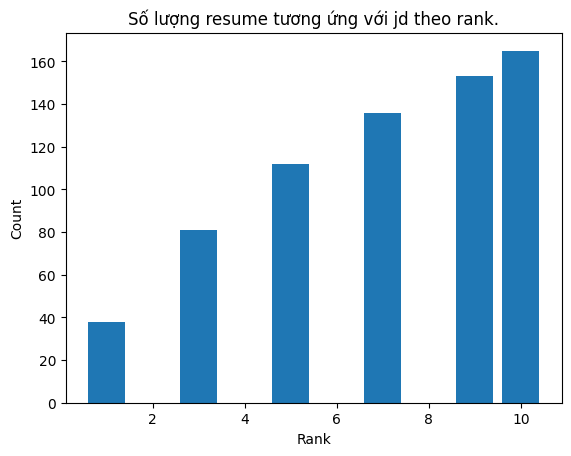

In [84]:
numbers = [1, 3, 5, 7, 9, 10]

# Vẽ biểu đồ
plt.bar(numbers, counts)
plt.xlabel('Rank')
plt.ylabel('Count')
plt.title('Số lượng resume tương ứng với jd theo rank.')
plt.savefig('rank.png')
plt.show()

In [85]:
ndcg = []
for k in [1, 3, 5, 7, 9, 10, 20, 50, 100]:
    NDCG = 0
    cnt = 0
    for num in range(len(jd_df)):
        try:
            NDCG += nDCG(evaluate[num * len(jd_df) : len(jd_df) * (num + 1)].sort_values(by='rank', ascending=True).reset_index(), data_csv, k)
            cnt += 1
        except:
            pass
    NDCG /= cnt
    ndcg.append(NDCG)
    print(f"NDCG@{k}", "=",  round(NDCG * 100, 2), "%")

NDCG@1 = 4.22 %
NDCG@3 = 7.0 %
NDCG@5 = 8.45 %
NDCG@7 = 9.36 %
NDCG@9 = 9.96 %
NDCG@10 = 10.35 %
NDCG@20 = 12.74 %
NDCG@50 = 15.28 %
NDCG@100 = 17.48 %


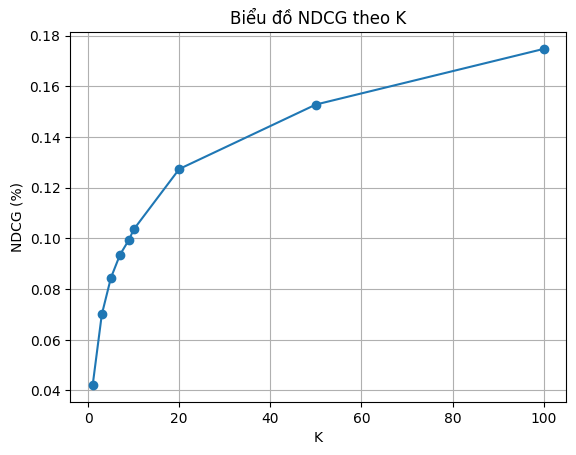

In [86]:
import matplotlib.pyplot as plt

# Dữ liệu NDCG
k_values = [1, 3, 5, 7, 9, 10, 20, 50, 100]

# Vẽ biểu đồ
plt.plot(k_values, ndcg, marker='o', linestyle='-')
plt.xlabel('K')
plt.ylabel('NDCG (%)')
plt.title('Biểu đồ NDCG theo K')
plt.grid(True)
plt.savefig('ndcg.png')
plt.show()



In [102]:
data_csv = pd.read_csv("Data/data.csv")

In [103]:
data_csv.rename(columns={'job_description_id': 'id_jd', 'resume_id': 'id_resume'}, inplace=True)
data_csv = data_csv.drop(columns=['overall_score'])
# In ra dataframe để kiểm tra kết quả
data_csv

,Unnamed: 0,id_jd,id_resume,experience,education,language,title_score,description_score,yoe_score,cosine_score_matching_skill,label
0,1,4288,4288,0.698490,0,0.0,0.566124,0.830855,NaN,0.636829,1
1,2,4385,4385,0.905469,0,1.0,1.000000,0.810938,NaN,0.452085,1
2,3,4515,4515,0.808731,0,0.0,0.696288,0.921175,NaN,0.292798,1
3,4,5184,5184,0.209289,0,0.0,0.209289,NaN,NaN,0.523493,1
4,5,4334,4334,0.669163,0,0.0,0.669163,NaN,NaN,0.677293,1
...,...,...,...,...,...,...,...,...,...,...,...
9723,8845,4982,4287,0.538705,0,0.0,0.374487,0.702924,NaN,0.218218,0
9724,8846,4982,4448,0.557140,0,0.0,0.390805,0.723474,NaN,0.113961,0
9725,8847,4982,4329,0.543104,0,0.0,0.377300,0.708909,NaN,0.150188,0
9726,8848,4982,4289,0.521524,0,0.0,0.327424,0.715624,NaN,0.218218,0


In [105]:
evaluate = evaluate.drop(columns= ['rank'])

In [106]:
df_merged = data_csv.merge(evaluate[['id_jd', 'id_resume', 'overall_score']], on=['id_jd', 'id_resume'], how='left')

df_merged

,Unnamed: 0,id_jd,id_resume,experience,education,language,title_score,description_score,yoe_score,cosine_score_matching_skill,label,overall_score
0,1,4288,4288,0.698490,0,0.0,0.566124,0.830855,NaN,0.636829,1,0.396751
1,2,4385,4385,0.905469,0,1.0,1.000000,0.810938,NaN,0.452085,1,0.899584
2,3,4515,4515,0.808731,0,0.0,0.696288,0.921175,NaN,0.292798,1,0.573825
3,4,5184,5184,0.209289,0,0.0,0.209289,NaN,NaN,0.523493,1,0.190197
4,5,4334,4334,0.669163,0,0.0,0.669163,NaN,NaN,0.677293,1,0.771586
...,...,...,...,...,...,...,...,...,...,...,...,...
9723,8845,4982,4287,0.538705,0,0.0,0.374487,0.702924,NaN,0.218218,0,0.397132
9724,8846,4982,4448,0.557140,0,0.0,0.390805,0.723474,NaN,0.113961,0,0.492876
9725,8847,4982,4329,0.543104,0,0.0,0.377300,0.708909,NaN,0.150188,0,0.550146
9726,8848,4982,4289,0.521524,0,0.0,0.327424,0.715624,NaN,0.218218,0,0.556669


In [107]:
df_merged['rank'] = df_merged.groupby('id_jd')['overall_score'].rank(ascending=False, method='first')

In [108]:
df_merged

,Unnamed: 0,id_jd,id_resume,experience,education,language,title_score,description_score,yoe_score,cosine_score_matching_skill,label,overall_score,rank
0,1,4288,4288,0.698490,0,0.0,0.566124,0.830855,NaN,0.636829,1,0.396751,7.0
1,2,4385,4385,0.905469,0,1.0,1.000000,0.810938,NaN,0.452085,1,0.899584,1.0
2,3,4515,4515,0.808731,0,0.0,0.696288,0.921175,NaN,0.292798,1,0.573825,1.0
3,4,5184,5184,0.209289,0,0.0,0.209289,NaN,NaN,0.523493,1,0.190197,1.0
4,5,4334,4334,0.669163,0,0.0,0.669163,NaN,NaN,0.677293,1,0.771586,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9723,8845,4982,4287,0.538705,0,0.0,0.374487,0.702924,NaN,0.218218,0,0.397132,28.0
9724,8846,4982,4448,0.557140,0,0.0,0.390805,0.723474,NaN,0.113961,0,0.492876,13.0
9725,8847,4982,4329,0.543104,0,0.0,0.377300,0.708909,NaN,0.150188,0,0.550146,6.0
9726,8848,4982,4289,0.521524,0,0.0,0.327424,0.715624,NaN,0.218218,0,0.556669,3.0


In [113]:
df_merged = df_merged[df_merged['label'] == 1]

In [117]:
df_merged

,Unnamed: 0,id_jd,id_resume,experience,education,language,title_score,description_score,yoe_score,cosine_score_matching_skill,label,overall_score,rank
0,1,4288,4288,0.698490,0,0.0,0.566124,0.830855,NaN,0.636829,1,0.396751,7.0
1,2,4385,4385,0.905469,0,1.0,1.000000,0.810938,NaN,0.452085,1,0.899584,1.0
2,3,4515,4515,0.808731,0,0.0,0.696288,0.921175,NaN,0.292798,1,0.573825,1.0
3,4,5184,5184,0.209289,0,0.0,0.209289,NaN,NaN,0.523493,1,0.190197,1.0
4,5,4334,4334,0.669163,0,0.0,0.669163,NaN,NaN,0.677293,1,0.771586,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
873,874,5318,5318,0.900413,0,0.0,1.000000,0.800826,NaN,0.137338,1,0.681184,1.0
874,875,5319,5319,0.368930,0,0.0,0.368930,NaN,NaN,0.000000,1,0.407681,1.0
875,876,5320,5320,0.316123,0,0.0,0.316123,NaN,NaN,0.000000,1,0.329011,1.0
876,877,5321,5321,0.238101,0,0.0,0.238101,NaN,NaN,0.000000,1,0.586665,1.0


In [115]:
ndcg = []
for k in [1, 3, 5, 7, 9, 10, 20, 50, 100]:
    NDCG = 0
    cnt = 0
    for num in range(len(df_merged)):
        if df_merged.loc[num, 'rank'] <= k:
            NDCG += 1 / (np.log(df_merged.loc[num, 'rank']+1)/np.log(2))
        cnt += 1
    NDCG /= cnt
    ndcg.append(NDCG)
    print(f"NDCG@{k}", "=",  round(NDCG * 100, 2), "%")

NDCG@1 = 86.67 %
NDCG@3 = 88.19 %
NDCG@5 = 88.94 %
NDCG@7 = 89.45 %
NDCG@9 = 89.87 %
NDCG@10 = 90.2 %
NDCG@20 = 90.64 %
NDCG@50 = 91.11 %
NDCG@100 = 91.24 %
